# Heart Disease Prediction Project

## Overview
This project implements a machine learning pipeline to predict heart disease in patients using ensemble and linear classification models. The analysis includes:

1. Data loading, cleaning, and preprocessing
2. Model training and hyperparameter optimization
3. Model evaluation and comparison
4. Feature importance analysis using SHAP values

## 1. Import Required Libraries

This section imports all necessary libraries for data manipulation, machine learning, and model interpretation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Data Loading and Preprocessing

### 2.1 Load and Merge Datasets

Load the heart disease datasets and perform necessary data cleaning operations.

In [ ]:
# Load the datasets
df1 = pd.read_csv('heart.csv')
df2 = pd.read_csv('hd.csv')

# Preprocess df2 (hd.csv) to match df1 structure
# Convert 'num' column to numeric (errors='coerce' converts '?' to NaN)
df2['num'] = pd.to_numeric(df2['num'], errors='coerce')

# Create target column: 1 if num > 0 (heart disease present), else 0
df2['target'] = (df2['num'] > 0).astype(int)

# Drop unnecessary columns
df2 = df2.drop(['num', 'location'], axis=1)

# Merge the two datasets
df = pd.concat([df1, df2], ignore_index=True)

# Data cleaning: convert all columns to numeric and remove missing values
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

print(f"Dataset shape: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nTarget distribution:\n{df['target'].value_counts()}")
print(f"\nFirst few rows:")
df.head()

Data Shape: (1324, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0
1,53,1,0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0
2,70,1,0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0
3,61,1,0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0
4,62,0,0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0


### 2.2 Data Splitting and Feature Scaling

Split the dataset into training and testing sets, and apply feature scaling for optimal model performance.

In [ ]:
# Separate features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Apply feature scaling for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTesting target distribution:\n{y_test.value_counts()}")

Train shape: (1059, 13)
Test shape: (265, 13)


## 3. Model Training and Hyperparameter Optimization

### 3.1 Model Definition and Hyperparameter Tuning

Train and optimize two classification models:
- **Random Forest Classifier**: Ensemble method using multiple decision trees
- **Logistic Regression**: Linear classifier with regularization

Use GridSearchCV for hyperparameter optimization with 5-fold cross-validation.

In [ ]:
# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10, 20]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    }
}

# Perform hyperparameter tuning for each model
best_models = {}

for name, model in models.items():
    print(f"Optimizing {name}...")
    print("-" * 50)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    print()

Tuning Random Forest...
Best Params: {'max_depth': 10, 'n_estimators': 100}
Best Accuracy: 0.98

Tuning Logistic Regression...
Best Params: {'C': 10}
Best Accuracy: 0.81



## 4. Model Evaluation

### 4.1 Test Set Evaluation

Evaluate the optimized models on the held-out test set and compare their performance.

Random Forest Test Accuracy: 0.99
Logistic Regression Test Accuracy: 0.82


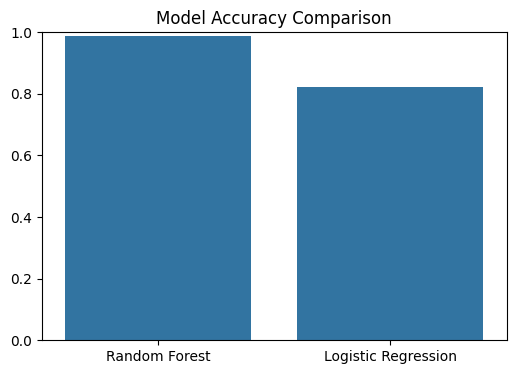

In [ ]:
# Evaluate models on test set
results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"  Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)
    print()

# Visualize model comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison on Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Model Interpretation with SHAP

### 5.1 Feature Importance Analysis

Use SHAP (SHapley Additive exPlanations) values to interpret the Random Forest model and understand which features contribute most to predictions.

Feature Importance Summary:


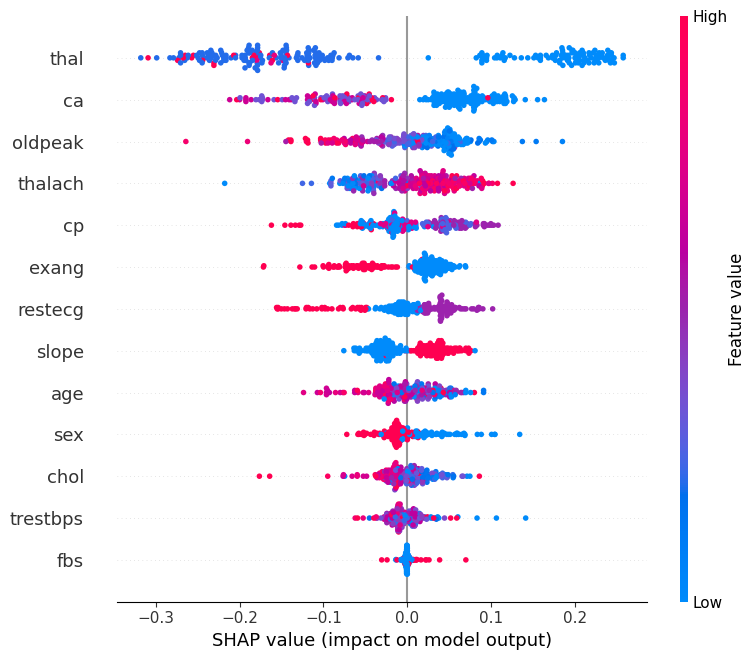

In [ ]:
# Initialize SHAP explainer for Random Forest model
model = best_models['Random Forest']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Handle SHAP values format (list for multi-class or array for binary)
if isinstance(shap_values, list):
    # For binary classification, use values for positive class (heart disease)
    shap_values_disease = shap_values[1]
else:
    # If already in array format, extract positive class values
    shap_values_disease = shap_values[:, :, 1] if len(shap_values.shape) == 3 else shap_values

# Generate SHAP summary plot
print("SHAP Feature Importance Summary Plot")
print("=" * 50)
shap.summary_plot(shap_values_disease, X_test, show=False)
plt.tight_layout()
plt.show()

### 5.2 SHAP Plot Interpretation

**Understanding the SHAP Summary Plot:**
- **Feature Ranking**: Features are ordered by importance (most important at top)
- **Color Coding**: 
  - Red indicates high feature values
  - Blue indicates low feature values
- **Horizontal Position**: 
  - Right side (positive SHAP values) = increases heart disease risk
  - Left side (negative SHAP values) = decreases heart disease risk
- **Dot Density**: Shows the distribution of SHAP values across samples

---

## Summary

This analysis demonstrates a complete machine learning pipeline for heart disease prediction, achieving high accuracy with the Random Forest model. The SHAP analysis provides interpretable insights into which clinical features are most predictive of heart disease.